In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 


%matplotlib inline

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Langkah 3: Load dataset
df = pd.read_csv('train.csv')

# Lihat 5 baris pertama
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# DATA CLEANING & FEATURE ENGINEERING

# 1. Isi missing value Age dengan median berdasarkan Pclass dan Sex (lebih akurat!)
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# 2. Isi 2 missing value Embarked dengan yang paling sering muncul
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# 3. Buat fitur baru yang sangat membantu model
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Kelompokkan title yang jarang
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                   'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Drop kolom yang tidak terlalu penting
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Cek lagi
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
IsAlone       0
Title         0
dtype: int64

In [14]:
# One-hot encoding
df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

# Lihat hasil akhir
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,22.0,1,0,7.2500,2,0,True,False,True,False,True,False,False
1,1,1,38.0,1,0,71.2833,2,0,False,False,False,False,False,True,False
2,1,3,26.0,0,0,7.9250,1,1,False,False,True,True,False,False,False
3,1,1,35.0,1,0,53.1000,2,0,False,False,True,False,False,True,False
4,0,3,35.0,0,0,8.0500,1,1,True,False,True,False,True,False,False


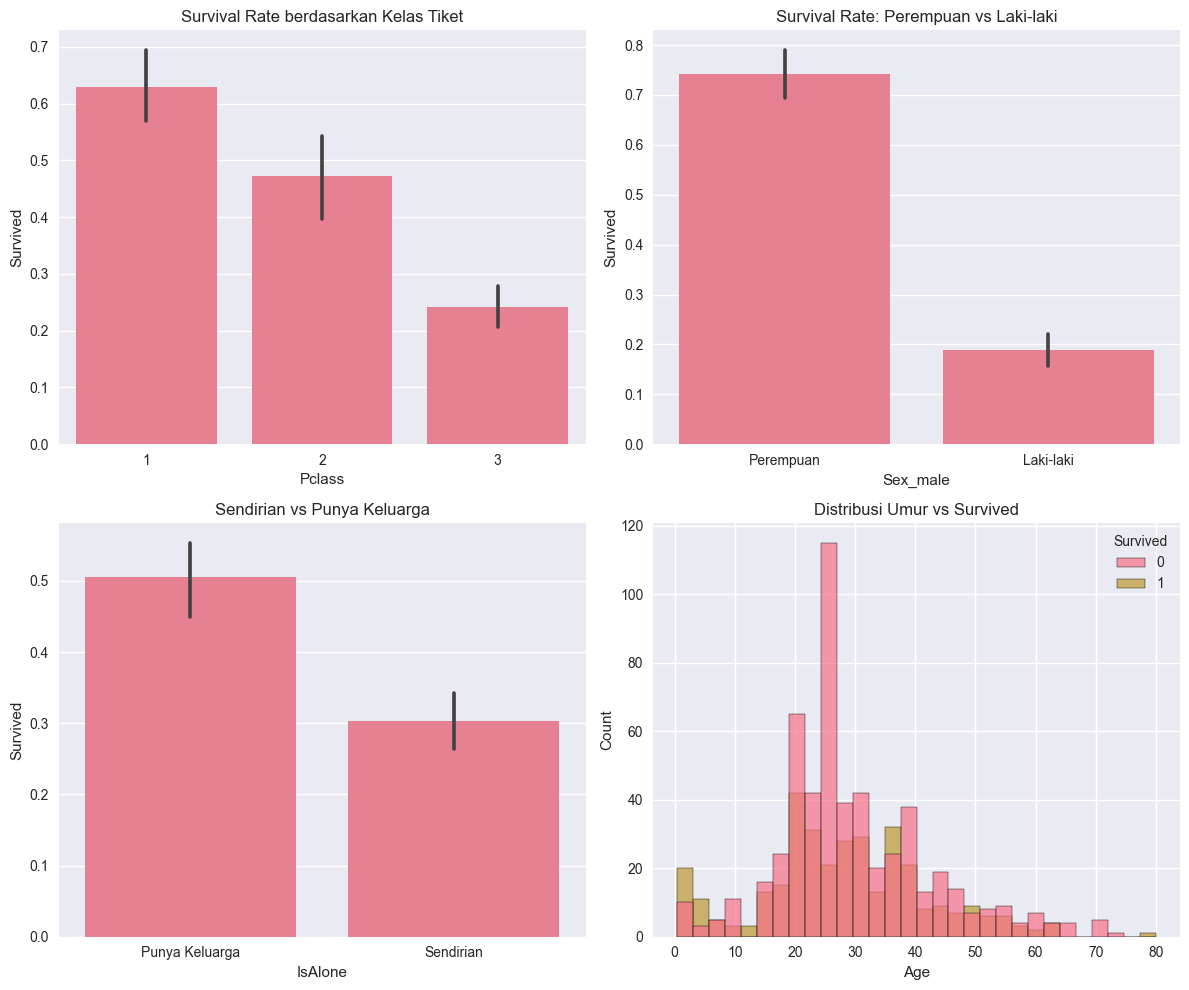

In [ ]:
# Visualisasi survival rate berdasarkan beberapa fitur penting
fig, axes = plt.subplots(2, 2, figsize=(12,10))

sns.barplot(x='Pclass', y='Survived', data=df, ax=axes[0,0])
axes[0,0].set_title('Survival Rate berdasarkan Kelas Tiket')

sns.barplot(x='Sex_male', y='Survived', data=df, ax=axes[0,1])
axes[0,1].set_title('Survival Rate: Perempuan vs Laki-laki')
axes[0,1].set_xticklabels(['Perempuan', 'Laki-laki'])

sns.barplot(x='IsAlone', y='Survived', data=df, ax=axes[1,0])
axes[1,0].set_title('Sendirian vs Punya Keluarga')
axes[1,0].set_xticklabels(['Punya Keluarga', 'Sendirian'])

sns.histplot(data=df, x='Age', hue='Survived', bins=30, alpha=0.7, ax=axes[1,1])
axes[1,1].set_title('Distribusi Umur vs Survived')

plt.tight_layout()
plt.show()https://www.kaggle.com/competitions/titanic/datahttps://www.kaggle.com/competitions/titanic/data

In [16]:
# Pisahkan fitur dan target
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=7,
    random_state=42,
    min_samples_split=5,
    min_samples_leaf=2
)

rf.fit(X_train, y_train)

# Prediksi
y_pred = rf.predict(X_test)

Akurasi Model: 0.8212 (82.12%)
               precision    recall  f1-score   support

Tidak Selamat       0.82      0.90      0.86       110
      Selamat       0.81      0.70      0.75        69

     accuracy                           0.82       179
    macro avg       0.82      0.80      0.81       179
 weighted avg       0.82      0.82      0.82       179



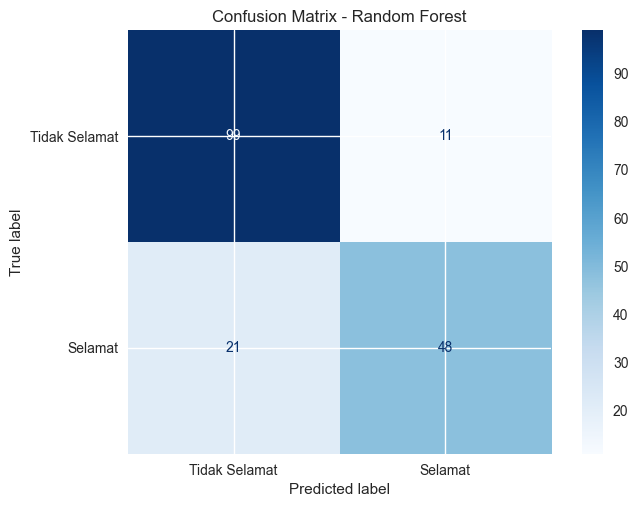

In [17]:
# Evaluasi Model
# Akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print(classification_report(y_test, y_pred, target_names=['Tidak Selamat', 'Selamat']))

# Confusion Matrix yang cantik
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tidak Selamat', 'Selamat'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

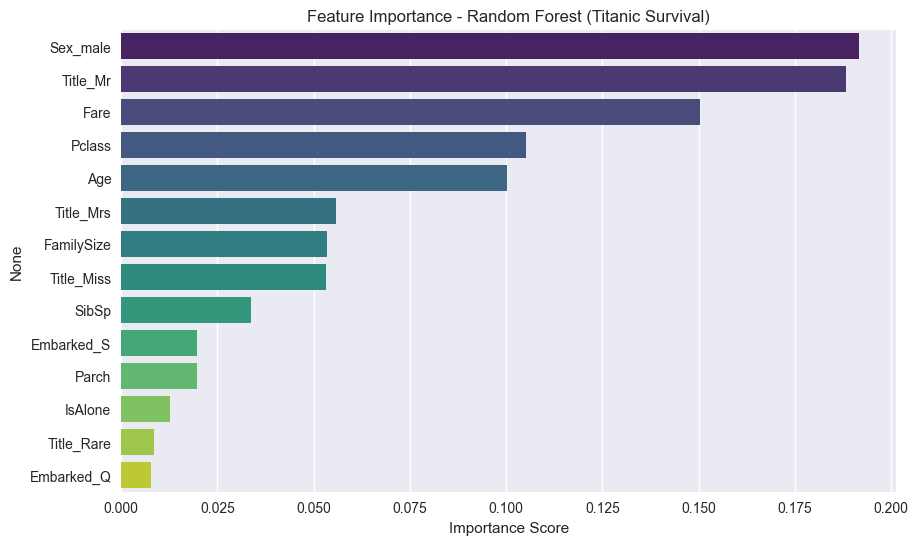

Urutan fitur paling berpengaruh:


Sex_male      0.1917
Title_Mr      0.1882
Fare          0.1503
Pclass        0.1052
Age           0.1001
Title_Mrs     0.0559
FamilySize    0.0534
Title_Miss    0.0532
SibSp         0.0337
Embarked_S    0.0196
Parch         0.0196
IsAlone       0.0126
Title_Rare    0.0087
Embarked_Q    0.0078
dtype: float64

In [18]:
# Feature importance
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importance.values, y=importance.index, palette='viridis')
plt.title('Feature Importance - Random Forest (Titanic Survival)')
plt.xlabel('Importance Score')
plt.show()

# Tampilkan nilai numeriknya juga
print("Urutan fitur paling berpengaruh:")
importance.round(4)